# Goals and methods
In this notebook, we will be using 'Segmentation_models.pytorch' to setup the different neural network architectures and experiment with different parameters. We will be using 'Albumentations' for data augmentation, given we have a pretty small dataset to work with. The whole implementation is based on pytorch, so that will be the 'glue' in our project, to put it all together

# 1. Imports

In [9]:
# Data tools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import json

# Data visualization
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Data loading
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

# 2. Global constants

In [53]:
IMAGE_DIR = 'data/images'
MASKS_DIR = 'data/masks'
DATA_DIR = 'data'

# 3. Loading dataset

### 3.1. Directories

In [54]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

### 3.2. Visualization

In [17]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### 3.3. Dataloader
Helper class for data extraction, transformation and preprocessing.

At the moment, we do not have one label per image (we have less labels than images, given our preprocessing methods), so we will extract image id from the annotations and will thus not be using all the images.

In [60]:
class Dataset(BaseDataset):
    """Solar Panel dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['solar panel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

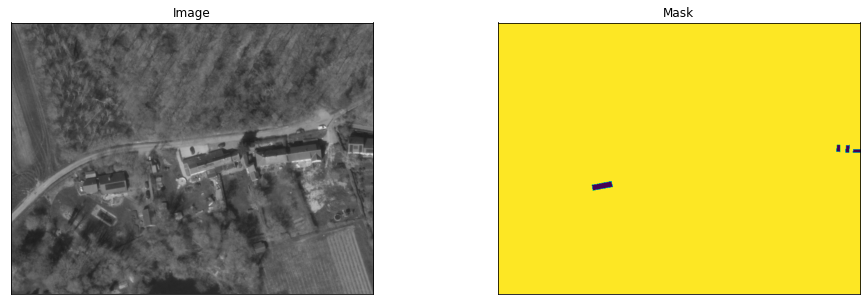

In [66]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['solar panel'])

image, mask = dataset[2] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

# 4. Augmentations
As we have a small dataset, we want to increase the amount of data and prevent model overfitting. 
For this task, we will apply a large number of different augmentations :
* horizontal flip
* affine transforms
* perspective transforms
* brightness/contrast/colors manipulations
* image bluring and sharpening
* gaussian noise
* random crops

To do so, we will use the library called 'Albumentations'.